### Preliminary analysis pipeline for turbulence project on autism data 

In this project we are using the following data:
1) Resting state MRI data from an open-source dataset (ABIDE I and II, Di Martino et al. 2014, 2017). This data has been postprocessed with a MATLAB script to extract phase data and a bunch of other functional connectivity metrics. Code and further details on what these metrics mean can be found in Deco and Kringelbach, 2020, Cell Reports.
2) Phenotypical data from ABIDE-subjects.
3) Quality checks of the ABIDE-scans.

### IMPORTANT CONSIDERATIONS ### 
This project is purely preliminary. It does NOT: 
1) Account for batch-effects. Since the data is from different sites with different scanner specifics, one would need to account for that in a "real" analysis pipeline.
2) Account for differences of Framewise Displacement (FD; movement in the scanner) between the autism and TD group. There is a difference there (see in the corresponding plot). One would need to apply a matching function on the data to account for that.
3) Use any kind of statistical model to assess group differences. Linear Mixed models would be needed to regress out any covariates (age, sex, scanner-site, FD, ...). 

The application of these issues would extend the scope of this project. Therefore, I just focused on preliminary analysis and some plots to show associations. 

In the first bit of this project, we want to understand the data structure of the postprocessed output files from MATLAB. To do so, we load the data of one random subject and check its structure.

In [1329]:
#Importing packages
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [1298]:
#Root path
root = "/Users/bened/Library/CloudStorage/OneDrive-FondazioneIstitutoItalianoTecnologia/Desktop/University/PhD_IIT/Courses/Python/final_project"

#Loading rsMRI data of one random subject.
mri_data = loadmat(root + "/data/mri/28757_turbulence_measures.mat") 
#Determine type 
print(type(mri_data)) # -> Dict 
#Check the keys of the data
print(mri_data.keys())

#There are 4 keys, we only need the output key, because this is where the data is stored 
output = mri_data['output']
#Determine type
print(type(output)) #Type is a numpy.ndarray array. 
print(output.shape) #(1,1)... It is stored nested, so we have to access the field...
output = output[0,0] 
print(type(output)) #Type is numpy.void. I had to ask LLM how to treat that.
print(output.dtype) #Now we see 11 fields, each with a key and data. This I think is because python treats the MATLAB structure as a dict.
print(output.dtype.names) #All the names of the metrices. 

# We just want to use the phases in this project
Phases = output["Phases"]
print(Phases.shape) # (1054,152) 
#First dimension is the spatial dimension. We have parcelated the brain into 1054 nodes based on a custom made atlas combining cortical Schaefer1000 and subcortical Tian54. 
#Second dimension is the temporal dimension. We have variable timepoints, depending on the length of the scan of the subject.

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'output'])
<class 'numpy.ndarray'>
(1, 1)
<class 'numpy.void'>
[('Turbulence', 'O'), ('Turbulence_Node', 'O'), ('Turbulence_RSN', 'O'), ('Information_Transfer', 'O'), ('Information_Cascade', 'O'), ('Information_Cascadeflow', 'O'), ('GlobalKuramoto', 'O'), ('Metastability', 'O'), ('Lambda', 'O'), ('LocalKuramoto', 'O'), ('Phases', 'O')]
('Turbulence', 'Turbulence_Node', 'Turbulence_RSN', 'Information_Transfer', 'Information_Cascade', 'Information_Cascadeflow', 'GlobalKuramoto', 'Metastability', 'Lambda', 'LocalKuramoto', 'Phases')
(1054, 152)


Now we want to use the Phase information of the subject to compute two metrices of the whole brain.
1) Metastability, which is the variability of synchronization.
2) And Global Synchonization, which is the strength of synchronization.

For both metrices, we have to compute a parameter called Kuramomto global order parameter (KGOP). It is computed by adding up the phases of all parcels to create a giant vector and then dividing its length by the number of parcels (1054). The length/magnitude of the resulting vector is the KGOP.  KGOP is a value as a function of time and denotes how synchronized the whole brain is at a given point in time. 

In [1301]:
# Convert each phase-information to a unit vector in the complex plane. I asked ChatGPT how to treat and use complex numbers with np :) 
v1 = np.exp(1j * Phases)

# Now, we want to add up all the vectors in the spatial dimension (across parcels) to compute the KGOP
#pre-allocate vector of KGOP with length of temporal dimension
KGOP = np.zeros(Phases.shape[1])

for timepoint in range(Phases.shape[1]): #Loop over timepoints
    curr_sum = 0 + 0j
    for parcel in range(Phases.shape[0]): #Loop over parcels
        curr_sum = curr_sum + v1[parcel,timepoint] #Add up vectors
    KGOP[timepoint] = abs(curr_sum)/Phases.shape[0] #Extract the magnitude of the resulting vector and normalize it 


#Finally, computing the metastability and global_synchronization values as the standard-devaition and the mean of the resulting KGOP
metastability = np.std(KGOP) 
global_synchronization = np.mean(KGOP) 

In the following chunk, we are visualizing how phase-information and the KGOP are related for one random subject. 

Explanation of the heatmaps: 
In the upper heatmap, phase-values (colorcoded) of all 1054 parcels (y-axis) are displayed as a function of time (x-axis). Therefore, each row of the heatmap displays the phase-values of one parcel over time. 

In the bottom heatmap, a 1D array of the KGOP is displayed (152 timepoints). Brighter colors mean higher values of KGOP. 

At timepoints, where the whole brain is "in synchrony" (i.e., where most of the parcels have aligned phase-values), the KGOP values should be high (brighter colors in the bottom heatmap). At timepoints however, where the brain is "asynchronous" (i.e., where most of the parcels have non-aligned phase-values), the KGOP values should be low (darker colors in the bottom heatmap). 

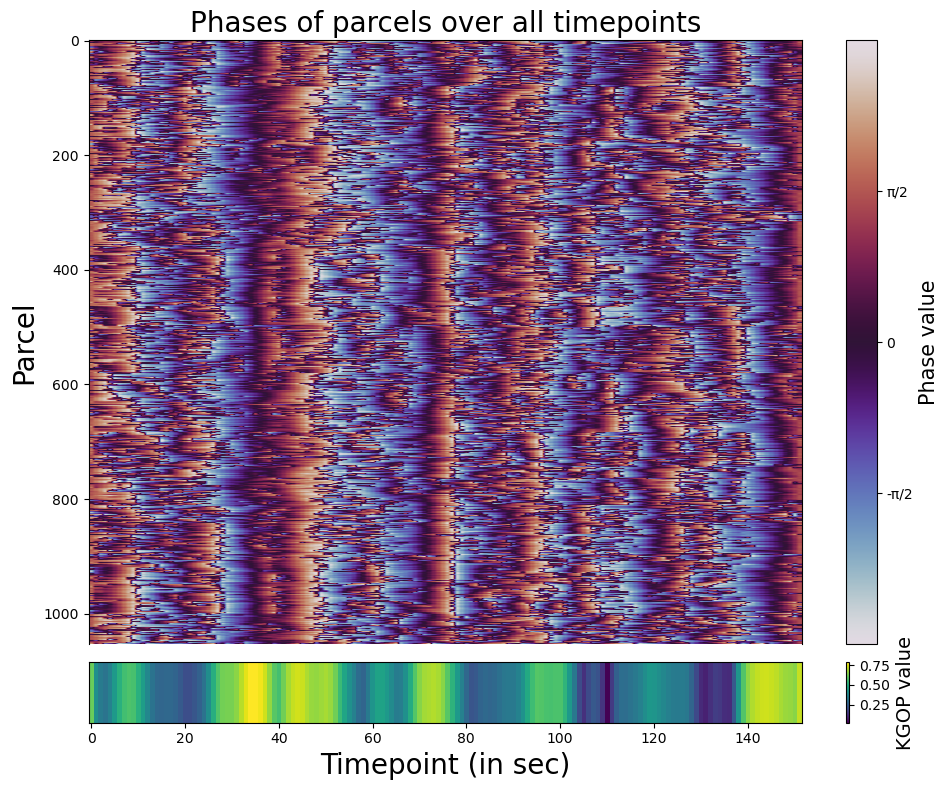

In [1304]:
#Here in some parts, I needed help from an LLM. Mostly because I wanted to align the two heatmaps nicely under each other, 
#and was not really happy with two individual plots. 

#Selection of parcels to display. For now, all Parcels.
curr_parcels = np.arange(0,1054)

# Create two stacked heatmaps: Top, heatmap of phases, bottom, heatmap of KGOP
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios':[10, 1]})  #The ratio thing I needed to ask LLM 

#First, the heatmap of the phases
im_1 = ax_1.imshow(Phases[curr_parcels,:], cmap = 'twilight', aspect = 'auto') #use of a cyclic colormap, since the data ranges from -pi to pi (which are the same value in the complex plane).
### LLM helped me here to set the labels and ticks
cbar_1 = fig.colorbar(im_1, ax = ax_1, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar_1.ax.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
cbar_1.set_label('Phase value', fontsize=15)
ax_1.set_xticks([])       
ax_1.set_xlabel('')       
ax_1.spines['bottom'].set_visible(False)
### until here
ax_1.set_ylabel('Parcel',fontsize = 20)          
ax_1.set_title('Phases of parcels over all timepoints', fontsize = 20)

#Second, the heatmap of the KGOP 
#Create a 1D array with simple ones to create the heatmaps 
KGOP_array = KGOP.reshape(1, -1)
im_2 = ax_2.imshow(KGOP_array, aspect='auto', cmap='viridis')
cbar_2 = fig.colorbar(im_2, ax=ax_2)
cbar_2.set_label('KGOP value', fontsize=14)
ax_2.set_yticks([])
ax_2.set_xlabel('Timepoint (in sec)',fontsize = 20)

plt.tight_layout()
plt.show()

To illustrate the idea of synchonous and asynchronous states/time-windows, we select two time-windows of the subject above where the phases are aligned (25-35 sec) and not aligned (125-135 sec). In the left panel, one can see that most of the parcels have approximately the same phase (blue colors), leading to high KGOP values. On the right panel, most of the parcels are not aligned, leading to lower values in KGOP. 

On the bottom, we see the lineplots of KGOP values of both, the asynchronous (purple) and synchronous (green) time-window overlayed in the same plot. This is to illustrate the accordingly higher KGOP values in the synchronous vs. asynchonous time-window. 

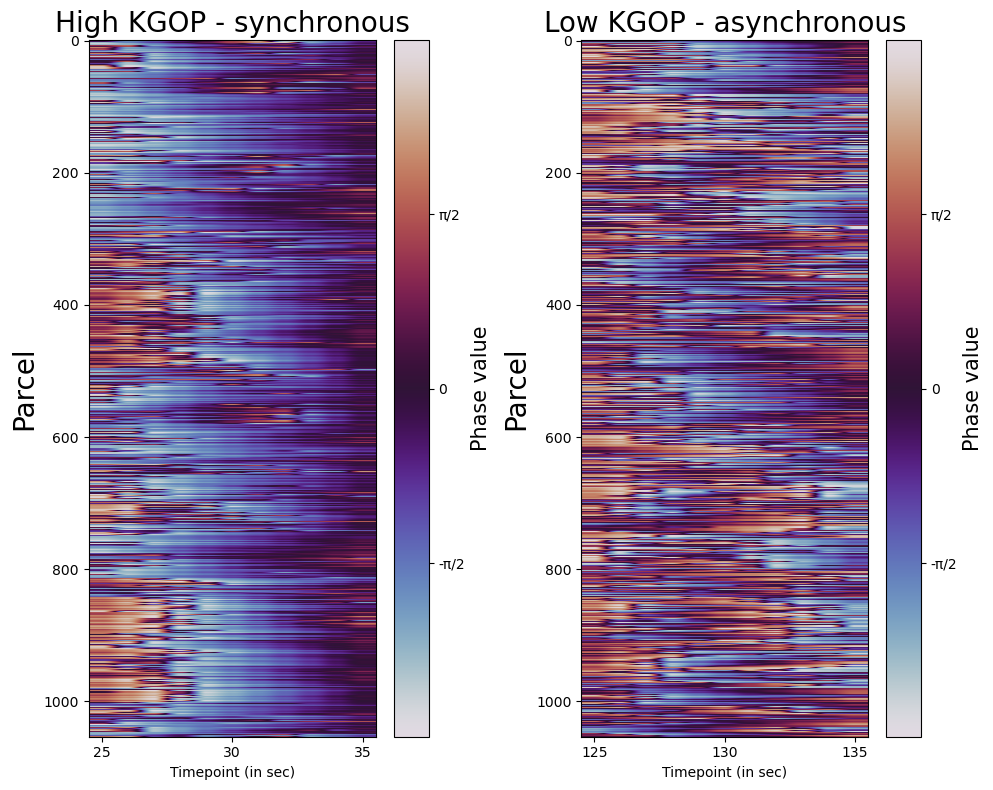

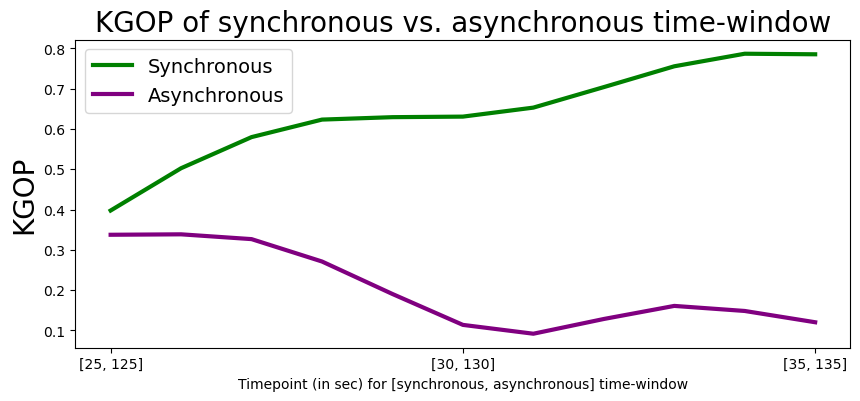

In [1307]:
fig, (ax_3, ax_4) = plt.subplots(1, 2, figsize=(10, 8))

#Time window where the brain seems to have high KGOP values (25-35 secs) 
im_3 = ax_3.imshow(Phases[:,25:36], cmap = 'twilight', aspect = 'auto')
cbar_3 = fig.colorbar(im_1, ax = ax_3, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar_3.ax.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
cbar_3.set_label('Phase value', fontsize=15)
ax_3.set_xlabel("Timepoint (in sec)") 
ax_3.set_xticks([0,5,10])
ax_3.set_xticklabels([25,30,35])
ax_3.set_ylabel('Parcel',fontsize = 20)          
ax_3.set_title('High KGOP - synchronous', fontsize = 20)

#Time window where the brain seems to have high KGOP values (125-140 secs) 
im_4 = ax_4.imshow(Phases[:,125:136], cmap = 'twilight', aspect = 'auto')
cbar_4 = fig.colorbar(im_1, ax = ax_4, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar_4.ax.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
cbar_4.set_label('Phase value', fontsize=15)      
ax_4.set_xlabel("Timepoint (in sec)") 
ax_4.set_xticks([0,5,10])
ax_4.set_xticklabels([125,130,135])     
ax_4.set_ylabel('Parcel',fontsize = 20)          
ax_4.set_title('Low KGOP - asynchronous', fontsize = 20)
plt.tight_layout()
plt.show()

# Lineplot of GKOP in high vs low synchrony
plt.figure(figsize=(10,4))
plt.plot(KGOP[25:36], color = "green", linewidth = 3, label = "Synchronous")
plt.plot(KGOP[125:136], color = "purple", linewidth = 3, label = "Asynchronous")
plt.title("KGOP of synchronous vs. asynchronous time-window", fontsize = 20)
plt.ylabel("KGOP", fontsize = 20)
plt.xticks([0, 5, 10], ["[25, 125]", "[30, 130]", "[35, 135]"]) #maybe I should drop my PhD for this line of code, but this is everything I can come up with at 2 a.m. in the night 
plt.xlabel("Timepoint (in sec) for [synchronous, asynchronous] time-window")
plt.legend(fontsize=14)
plt.show()

Next, we are loading the data of all subjects and computing the metastability and global synchronization metrices. Here, we are following the same procedure as above, while looping over multiple subjects. 

In [1310]:
#First, load in all the paths to the MRI MATLAB data
data_path = Path(root+"/data/mri/")
subject_paths = list(sorted(data_path.glob("*.mat")))

#List of subjects that we have post-processed using subject_paths
#Pre-allocation
subid_list = []
for curr_sub in subject_paths: 
    curr_ID = str(curr_sub).split("mri/")[1].split("_turbulence_measures.mat")[0] #Horrific, but does its job...
    subid_list.append(int(curr_ID))

#Convert to a pandas data frame 
subid_list = pd.DataFrame(subid_list)
subid_list.columns = ["subid"]

#Then, load in the phenotypical data as well as the motion data with pandas
motion = pd.read_csv(root+"/data/pheno/motion.csv")
pheno = pd.read_csv(root + "/data/pheno/pheno.csv", encoding='cp1252') #Some of the columns had strange datatypes... so i had to use this to handle different tyopes of data. 

#We only need the subid and the mean framewise displacement (FD; a measure of participant movement in the scanner) from the motion data. 
motion = motion[["subid","mean_fd"]]
#We only need the age_years, the subid, the diagnosis and the sex from the pheno data
pheno = pheno[["subid","diagnosis","age_years","sex"]]

#Now, we want to merge the pheno and the motion data by subid
subject_pheno = pheno.merge(motion, on="subid")

#And now, we want to merge the resulting data-frame with all the subids I have postprocessed with MATLAB
subject_data = subject_pheno.merge(subid_list, on="subid")
subject_data = subject_data.set_index("subid")

#Looping over subjects to load data and compute metastability and global synchonization. 
#All of the steps are explained in detail above. 

#pre allocation of subject data 
subject_data["metastability"] = np.zeros(len(subject_data))
subject_data["global_synchronization"] = np.zeros(len(subject_data))

for curr_path in subject_paths: 
    curr_ID = str(curr_path).split("mri/")[1].split("_turbulence_measures.mat")[0] #Horrific, but does its job...
    mri_data = loadmat(str(curr_path))
    output = mri_data['output']
    output = output[0,0] 
    Phases = output["Phases"]
    nTime = Phases.shape[1]
    nParcels = Phases.shape[0]
    v1 = np.exp(1j * Phases)
    KGOP = np.zeros(Phases.shape[1])
    for timepoint in range(nTime): #Loop over timepoints
        curr_sum = 0 + 0j
        for parcel in range(nParcels): #Loop over parcels
            curr_sum = curr_sum + v1[parcel,timepoint] #Add up vectors
        KGOP[timepoint] = abs(curr_sum)/Phases.shape[0] #Extract the magnitude of the resulting vector and normalize it 
    
    #Finally, computing the metastability and global_synchronization values as the standard-deviation and the mean of the resulting KGOP
    subject_data.loc[int(curr_ID),"metastability"] = np.std(KGOP) 
    subject_data.loc[int(curr_ID),"global_synchronization"] = np.mean(KGOP)

#Filtering of Data
subject_data = subject_data.dropna() #Drop any kind of NANs from the data frame 
subject_data = subject_data[subject_data["mean_fd"] < 0.5] #Any movement in the scanner that is > 0.5mm mean_FD should be removed 

subject_data

/var/folders/ym/rxly4jfs4bj6c16y12qndnz00000gn/T/ipykernel_14274/1930816240.py:18: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(root + "/data/pheno/pheno.csv", encoding='cp1252') #Some of the columns had strange datatypes... so i had to use this to handle different tyopes of data.


,diagnosis,age_years,sex,mean_fd,metastability,global_synchronization
subid,,,,,,
28752,Autism,13.076712,Male,0.109524,0.173755,0.431998
28754,Autism,9.298630,Male,0.231060,0.179255,0.486390
28761,Autism,11.484932,Male,0.151662,0.199369,0.609870
28765,Autism,12.065753,Male,0.181421,0.177971,0.396845
28768,Autism,11.358904,Male,0.108454,0.185462,0.405892
...,...,...,...,...,...,...
28837,Control,11.758904,Male,0.091756,0.212645,0.484703
28841,Control,8.723288,Female,0.377893,0.201766,0.419185
28842,Control,8.408219,Male,0.319451,0.134630,0.338348


Before we start with the group-level analysis, we should check FD between groups (Autism vs. TD). If there is a systematic difference between the groups, this might load into the analysis.

Text(0.5, 1.0, 'Framewise Discplacement ~ Autism vs. TD')

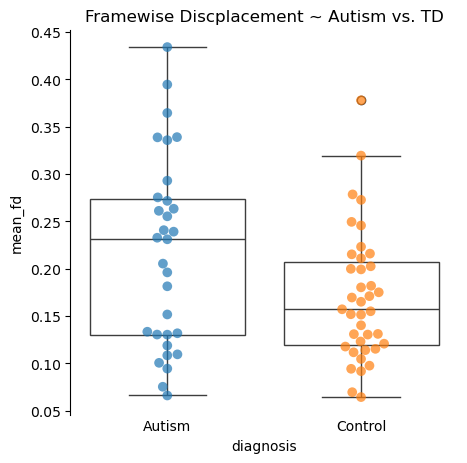

In [1313]:
#Getting both subject as well as control data
autism_data = subject_data[subject_data["diagnosis"] == "Autism"]
TD_data = subject_data[subject_data["diagnosis"] == "Control"]

#Framewise Displacement for autism vs. TD
f,ax = plt.subplots(figsize=(5,5))
sns.swarmplot(x="diagnosis", y="mean_fd", data=subject_data, hue="diagnosis", alpha=0.7, size = 7)
sns.boxplot(x="diagnosis", y="mean_fd", data=subject_data, boxprops={'facecolor':'none'})
sns.despine(bottom=True)
ax.tick_params(axis="x", length=0) 
plt.title("Framewise Discplacement ~ Autism vs. TD")

The Autism group has elevated scanner movement compared to TD. This is problematic and has to be accounted for. In R, this can be done with a matching function, i.e., matching each subject from both groups on FD. Unfortunately, here I cannot do much about it.

Next, we investigate associations between Metastability/Global Synchronization with diagnosis (Autism vs. Typically developed). Our hypothesis is, that both Metastability as well as Global Synchronization values are reduced in Autism compared to TD (based on the literature). 

Text(0.5, 1.0, 'Global Synchronization ~ Autism vs. TD')

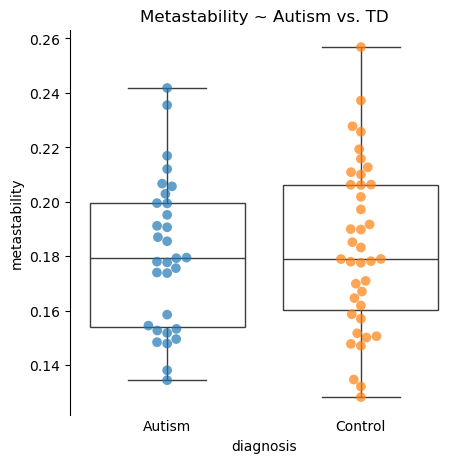

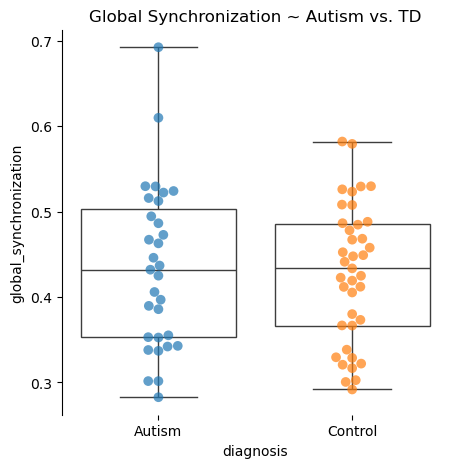

In [1317]:
#Metastability: Scatterplot overlayed with boxplot
f,ax = plt.subplots(figsize=(5,5))
sns.swarmplot(x="diagnosis", y="metastability", data=subject_data, hue="diagnosis", alpha=0.7, size = 7)
sns.boxplot(x="diagnosis", y="metastability", data=subject_data, boxprops={'facecolor':'none'})
sns.despine(bottom=True)
ax.tick_params(axis="x", length=0) 
plt.title("Metastability ~ Autism vs. TD")

#Global Synchronization 
plt.figure(figsize=(5,5))
sns.swarmplot(x="diagnosis", y="global_synchronization", data=subject_data, hue="diagnosis", alpha=0.7, size = 7)
sns.boxplot(x="diagnosis", y="global_synchronization", data=subject_data, boxprops={'facecolor':'none'})
sns.despine(bottom=True)
ax.tick_params(axis="x", length=0) 
plt.title("Global Synchronization ~ Autism vs. TD")

Visually, there is not much of a difference between the groups. But of course, models are needed to regress out the covariates...

For example, in functional connectivity, an infamous issue are motion related conenctivity artifacts (Power et al., 2011). The authors showed, that even sub-millimeter movements in the scanner can induce systematic artifacts in functional connectivity. To investigate that visually in our data, let us see the association of movement in the scanner (framewise displacement) with both metrices. 

<Axes: title={'center': 'Global Synchronization ~ Mean Framewise Displacement'}, xlabel='mean_fd', ylabel='global_synchronization'>

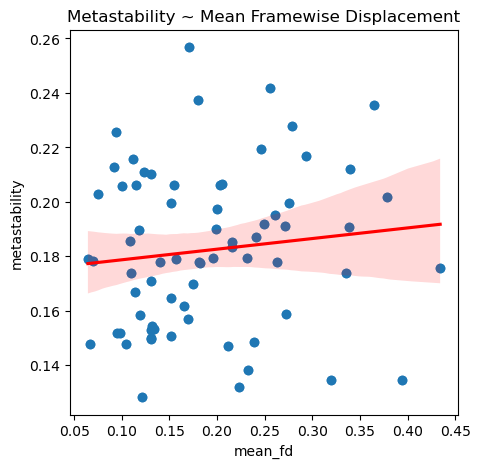

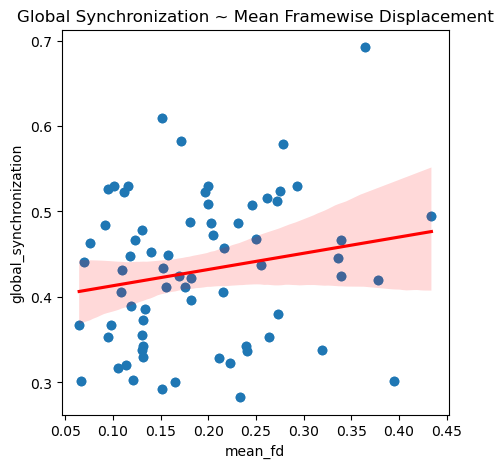

In [1320]:
#Plots of mean_fd on the x axes and measures on the y-axes to investigate association with movement

#1) Metastability
plt.figure(figsize=(5,5))
plt.scatter(x="mean_fd", y="metastability", data=subject_data)
plt.title("Metastability ~ Mean Framewise Displacement")
sns.regplot(
    x="mean_fd", y="metastability", data=subject_data,
    scatter=True, line_kws={"color": "red"}
)

#2) Global Synchronization
plt.figure(figsize=(5,5))
plt.scatter(x="mean_fd", y="global_synchronization", data=subject_data)
plt.title("Global Synchronization ~ Mean Framewise Displacement")
sns.regplot(
    x="mean_fd", y="global_synchronization", data=subject_data,
    scatter=True, line_kws={"color": "red"}
)

As expected, both measure seem to increase with FD... This necessitates regression of FD even more. Since we did not cover that in the course, I will not use any statistics, but this is something to investigate. 

Finally, maybe there is an association of age with the two metrices? 

<Axes: title={'center': 'Global Synchronization ~ age (in years)'}, xlabel='age_years', ylabel='global_synchronization'>

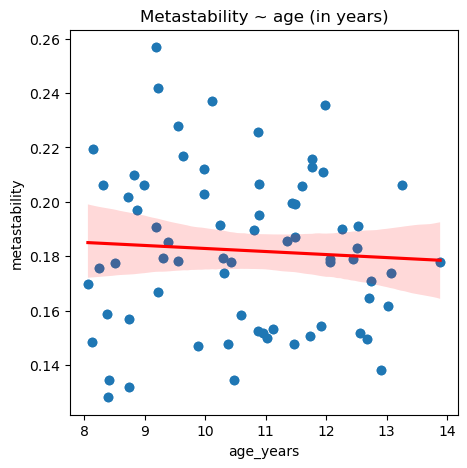

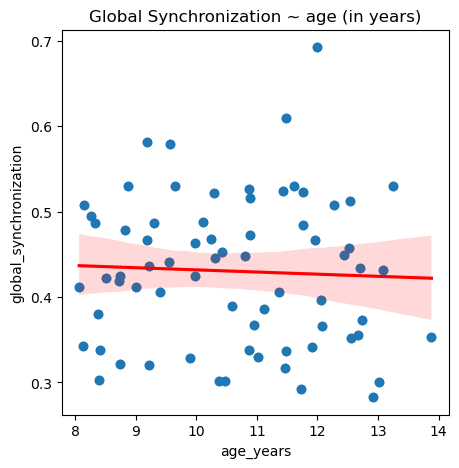

In [1324]:
#Plots of age on the x axes and measures on the y-axes to investigate association with age

#1) Metastability
plt.figure(figsize=(5,5))
plt.scatter(x="age_years", y="metastability", data=subject_data)
plt.title("Metastability ~ age (in years)")
sns.regplot(
    x="age_years", y="metastability", data=subject_data,
    scatter=True, line_kws={"color": "red"}
)

#2) Global Synchronization
plt.figure(figsize=(5,5))
plt.scatter(x="age_years", y="global_synchronization", data=subject_data)
plt.title("Global Synchronization ~ age (in years)")
sns.regplot(
    x="age_years", y="global_synchronization", data=subject_data,
    scatter=True, line_kws={"color": "red"}
)

Visually, there is not much going on here...